<a href="https://colab.research.google.com/github/cafalchio/EXvivo/blob/main/spike_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spike detection

Single channels were extracted from Intan .dat files. The signal was filtered (300 - 5kHz) using MNE package. The signal was normalized using mean and standard deviation as below.

x - mean(x) / std(x) 

The detection treshold was defined as the signal using:

treshold = mean(x) + std(x)*6

The waveforms above or below the negative treshold were then aligned by its peak and clustered using k-means.


### Install dependencies

In [ ]:
!pip install lspopt -q
!pip install MNE -q
!pip install PyQt5 -q

     |████████████████████████████████| 7.4 MB 5.1 MB/s 
     |████████████████████████████████| 8.3 MB 4.2 MB/s 
     |████████████████████████████████| 59.9 MB 172 kB/s 
     |████████████████████████████████| 317 kB 57.4 MB/s 


#### Import packages and append data folder

In [ ]:
import mne
import matplotlib as mpl
import glob, os
import mmap
from tqdm.notebook import tqdm
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct
from resource import getrusage, RUSAGE_SELF
import gc
gc.enable()

# load data
sys.path.append("/content/drive/MyDrive/aHuman_data_Mark/load_intan_rhd_format")
from load_intan_rhd_format import *
from scipy import signal

# plot parameters
# mpl.use('Qt5Agg')
mpl.rcParams['agg.path.chunksize'] = 10000
%matplotlib inline

#### Define recording class

Class that open and pre-process data

In [ ]:
class Recording:
    '''class that reads metadata from a intan recording. It will scan a folder
    to find all data files and metadata.
    Ex: record = Recording(path to data)
    '''
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.info = glob.glob(path_to_data+'/*.rhd')[0]
        self.metadata = read_data(glob.glob(path_to_data+'/info.rhd')[0])
        self.sample_rate = self.metadata['frequency_parameters']['amplifier_sample_rate']
        self.time = glob.glob(path_to_data+'/time.dat')[0]
        self.data_files = sorted(glob.glob(path_to_data+'/amp*.dat'))
        self.aux_files = sorted(glob.glob(path_to_data+'/aux*.dat'))
        self.board_files = sorted(glob.glob(path_to_data+'/board*.dat'))
        self.vdd_files = glob.glob(path_to_data+'/vdd*.dat')
        self.channels = self.set_amp_files()
        self.channel_names = self.channels.keys()
        self.n_samples, self.timestamp = self.read_timestamp()
        self.data = np.array([], np.int16)
        print(f'Found in folder {len(self.data_files)} amplifier channels')
        print(f'Found in folder {len(self.aux_files)} axiliary channels')
    
    def set_amp_files(self):
        channels = {}
        for channel in self.metadata['amplifier_channels']:
            channel_name = channel['custom_channel_name']  
            channels[channel_name] = glob.glob(f'{self.path_to_data}/amp-{channel_name}.*')[0]
        return channels

    def read_timestamp(self):
        '''Function that reads timestamp from Intan recording'''
        size = os.path.getsize(self.time)
        num_samples = size/4
        n_samples = num_samples
        timestamp = np.fromfile(self.time, dtype=np.int32)
        timestamp = timestamp/self.sample_rate
        print(f'Reading {len(timestamp)/(60 * self.sample_rate):.2f} minutes of recording.')
        return int(n_samples), timestamp

    def read_channel(self, channel_idx):
        '''Function that reads a single recording channel'''
        channel_file = self.channels[channel_idx]
        # print(f"Reading: {self.data_files[channel_idx].split('/')[-1]}")
        size = os.path.getsize(channel_file)
        num_samples = size/(1 * 2)
        if num_samples != self.n_samples:
            print('Error reading file, missing samples!')
        data_ch = np.fromfile(channel_file, dtype=np.int16)
        self.data = data_ch * 0.195
        self.get_memory_use()
        return self.data
    
    def plot_raw_sample(self):
        ax = plt.figure(figsize=(20,6))
        ax = plt.plot(1/self.timestamp[25000:50000], self.data[25000:50000])
        ax = plt.ylabel('Voltage uV')
        ax = plt.xlabel('Time (s)')
        plt.show()
        plt.close()
    
    @staticmethod
    def get_memory_use():
        '''Auxiliary function to check memory use
        '''
        mem = getrusage(RUSAGE_SELF).ru_maxrss/1024000
        print(f'Memory use: {mem:.1f}Gb')
    
    def load_amp_channels(self, ch_idxs):
        '''
        Read a list of channels and transform from microvolts to volts
        '''
        res = [self.read_channel(ch_idx)/1000000 for ch_idx in ch_idxs] # from microvolts to volts
        # self.get_memory_use()
        return res
    
    def load_mne_channels(self, ch_idxs):
        ''' Load channels by its name ex(A-001) and 
        transform the EEG to MNE objects, can open 20 
        EEGs per time. It is recommended to open 
        a chunk of 8 files at time
        '''
        # freqs = (50, 100, 150, 200, 250)
        data = self.load_amp_channels(ch_idxs)
        ch_types = len(ch_idxs) * ['eeg']
        info = mne.create_info(ch_names=ch_idxs, sfreq=self.sample_rate, ch_types=ch_types)
        data =  mne.io.RawArray(np.array(data), info, verbose='ERROR')
        data = data.notch_filter(np.arange(50, 251, 50)) # Filter 50Hz
        # data = data.filter(l_freq=1, h_freq=200)
        # print('Removing 50Hz and resample to 2.4Khz')
        # data = data.resample(sfreq=600)
        self.get_memory_use()
        print('Done!')
        return data

## Function to get spikes based on standart deviation treshold
def get_spikes(data, sr = 25000, spike_window_ms=2, sd_tresh=6, offset=20, max_thresh_sd=8):
    # data, spike_window=50, tf=6, offset=20
    '''Find spikes in the time series based on treshold
    Inputs:
        data(numpy array): 
                Time series of sampled data
        sample_rate(int): 
                Sample rate
        sd_tresh(int): 
                Treshold in number of standard deviation 
        offset(int): 
                Window offset to increase the wave window size
        max_tresh_sd(int):
                Maximum value of a wave in standart deviation
    Return:
        spike_samp(array): 
                Array of timestamps of the waveforms
        wave_form(array):
                Waveforms found by treshold
    '''
    spike_window = int(sr/1000) * spike_window_ms
    # Calculate threshold based on data mean and std
    thresh = np.mean(np.abs(data)) + sd_tresh * np.std(np.abs(data))
    max_tresh = np.mean(np.abs(data)) + max_thresh_sd * np.std(np.abs(data))
    min_tresh = -4 * np.mean(np.abs(data)) 

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0] 
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]
            
            # Check if data in window is inside thresholds (artifact rejection)
            if np.max(tmp_waveform) < max_tresh:# 
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) + i
                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]
                # Append data
                #Check again:
                if np.max(tmp_waveform) < max_tresh and np.min(tmp_waveform) > min_tresh:
                    spike_samp = np.append(spike_samp, tmp_samp)
                    wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
    
    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]
    print(f'Found {len(spike_samp)} candidates waveforms')
    
    return spike_samp, wave_form

# Cluster k-means
def k_means(data, num_clus=4, steps=100):
    '''Cluster data using k-means algorithm
    Input:
        data(array): 
            Waveform samples
        num_clus(int): 
            Number of clusters to separate the data
        steps(int): 
            Number of iteractions to find cluster
    Return:
        cluster, 
        center_init
        distance
        '''
    # Convert data to Numpy array
    cluster_data = np.array(data)
    
    # Initialize by randomly selecting points in the data
    center_init = np.random.randint(0, cluster_data.shape[0], num_clus)

    # Create a list with center coordinates
    center_init = cluster_data[center_init, :]

    # Repeat clustering  x times
    for _ in range(steps):

        # Calculate distance of each data point to cluster center
        distance = []
        for center in center_init:
            tmp_distance = np.sqrt(np.sum((cluster_data - center)**2, axis=1))
            
            # Adding smalle random noise to the data to avoid matching distances to centroids
            tmp_distance = tmp_distance + np.abs(np.random.randn(len(tmp_distance))*0.0001)
            distance.append(tmp_distance)

        # Assign each point to cluster based on minimum distance
        _, cluster = np.where(np.transpose(distance == np.min(distance, axis=0)))

        # Find center of mass for each cluster
        center_init = []
        for i in range(num_clus):    
            center_init.append(cluster_data[cluster == i, :].mean(axis=0).tolist())
            
    return cluster, center_init, distance

def plot_waveforms(wave_form, n_samples = 200):
    '''Plot a sample of waveforms
    Inputs:
        spike_samp(np array): 
                Timestamp of detected spikes
        wave_form(np array): 
                2D array of waveforms
        n_samples(int): 
                Number of random samples to be ploted
    '''
    mean_wave = np.median(wave_form, axis=0)
    ax = plt.figure(figsize=(15, 5))
    for i in range(n_samples):
        spike = np.random.randint(0, wave_form.shape[0])
        ax = plt.plot(wave_form[spike, :])
    ax = plt.xlim([5, len(mean_wave)-10])
    ax = plt.ylim([-5, mean_wave.max()+10])
    ax = plt.xlabel('Units of sample rate', fontsize=20)
    ax = plt.ylabel('Normalized amplitude', fontsize=20)
    ax = plt.title('spike waveforms', fontsize=23)
    plt.savefig('waveforms.jpg')
    plt.show()

def improve_sample(wave):
    #Increase sample rate and interpolate
    x = np.linspace(0,50,50)
    newx = np.linspace(0,50,200)
    return np.interp(newx, x, wave)

def check_wave_outliers(waveforms):
    #remove nans
    waveforms = waveforms[~np.isnan(waveforms).any(axis=1), :]
    np.array([improve_sample(wave) for wave in wave_form])
    return waveforms
    

## Read data and select channels and filter line noise

In [ ]:
%%time
rec = Recording('/content/drive/MyDrive/aHuman_data_Mark/human_151126_135612')
raw_data = rec.load_mne_channels([
                                #   'A-000', 'A-001', 'A-002', #'A-003', 'A-004', 
                                #   'C-005', 'C-006', #'A-007', 'A-008', 'A-009',
                                  'A-012', 'A-011', #'A-012', 'A-013', 'A-014'
                                  ])


Reading Intan Technologies RHD2000 Data File, Version 1.4

n signal groups 7
Found 110 amplifier channels.
Found 6 auxiliary input channels.
Found 2 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 25.00 kS/s.
Done!  Elapsed time: 0.3 seconds
Reading 46.15 minutes of recording.
Found in folder 110 amplifier channels
Found in folder 6 axiliary channels
Memory use: 1.5Gb
Memory use: 2.6Gb
Memory use: 3.1Gb
Memory use: 3.7Gb
Memory use: 5.8Gb
Done!


## Filter data to LFP (2-100Hz) and spike (300 - 5000Hz)

In [ ]:
# eeg_data =  raw_data.copy().filter(l_freq = 2, h_freq=300)
# eeg_data = eeg_data.resample(1000)
spike_data = raw_data.copy().filter(l_freq = 300, h_freq=5000)

In [ ]:
data = spike_data.get_data()[1] - spike_data.get_data()[-2]
data = (data - data.mean()) / data.std()

Found 220 candidates waveforms
Found 359 candidates waveforms


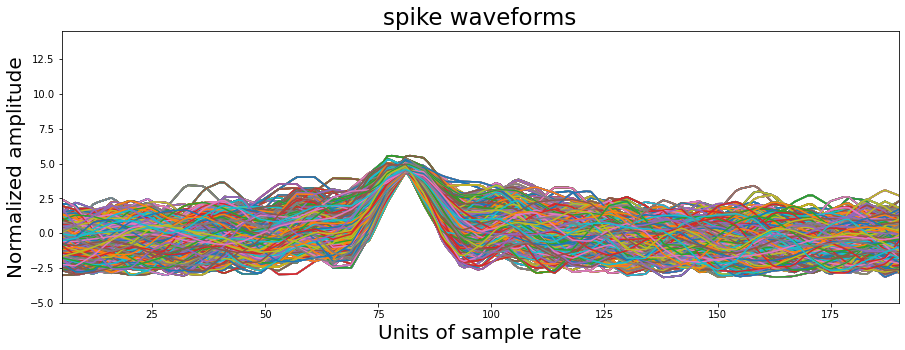

<Figure size 432x288 with 0 Axes>

In [ ]:
# Get positive and negative spikes based on sd treshold
spike_samp1, wave_form1 = get_spikes(data, spike_window_ms=1, sd_tresh=6, offset=5, max_thresh_sd=7)
spike_samp2, wave_form2 = get_spikes(-1*data, spike_window_ms=1, sd_tresh=6, offset=5, max_thresh_sd=8)
wave_form1 = wave_form1[~np.isnan(wave_form1).any(axis=1), :]
wave_form2 = wave_form2[~np.isnan(wave_form2).any(axis=1), :]
spike_samp = sorted(np.unique(np.concatenate( (spike_samp1, spike_samp2), axis=0)))
wave_form = np.vstack((wave_form1, wave_form2))
wave_form = check_wave_outliers(wave_form)
wave_form = np.array([improve_sample(wave) for wave in wave_form])
plot_waveforms(wave_form, n_samples = 10000)
plt.savefig('waveforms.jpg')

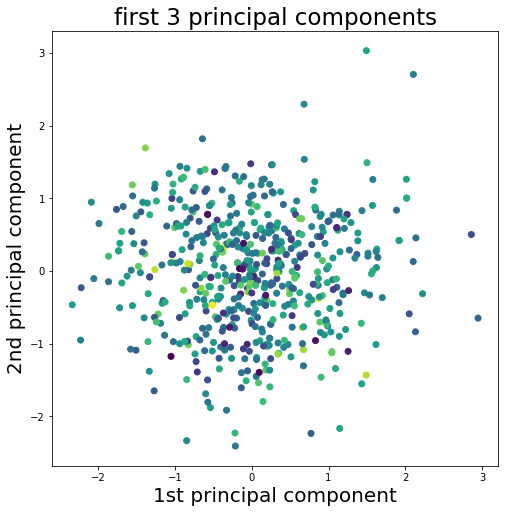

In [ ]:
import sklearn as sk
from sklearn.decomposition import PCA

# Apply min-max scaling
scaler= sk.preprocessing.MinMaxScaler()
dataset_scaled = scaler.fit_transform(wave_form)

# Do PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(dataset_scaled)

# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component', fontsize=20)
ax.set_ylabel('2nd principal component', fontsize=20)
ax.set_title('first 3 principal components', fontsize=23)

fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

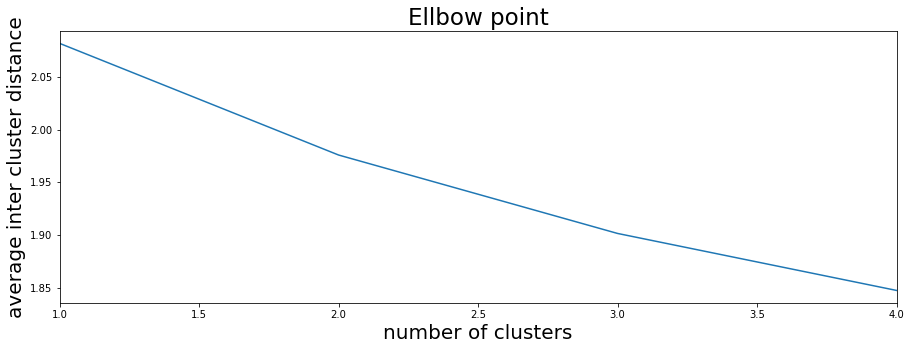

In [ ]:
max_num_clusters = 4
average_distance = []
for run in range(20):
    tmp_average_distance = []
    for num_clus in range(1, max_num_clusters +1):
        cluster, centers, distance = k_means(pca_result, num_clus)
        tmp_average_distance.append(np.mean([np.mean(distance[x][cluster==x]) for x in range(num_clus)], axis=0))
    average_distance.append(tmp_average_distance)
    
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(1, max_num_clusters +1), np.mean(average_distance, axis=0))
ax.set_xlim([1, max_num_clusters])
ax.set_xlabel('number of clusters', fontsize=20)
ax.set_ylabel('average inter cluster distance', fontsize=20)
ax.set_title('Ellbow point', fontsize=23)
plt.show()

Estimated number of noise points: 1


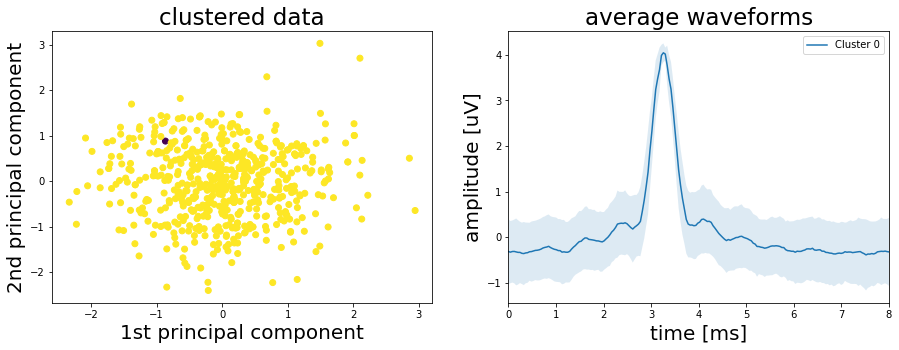

In [ ]:
num_clus = 1
sf = 25000
cluster, centers, distance = k_means(pca_result, num_clus)
for i in set(cluster) :
    if sum(cluster[cluster == i]) < 10:
        cluster[cluster[i]] = -1

n_clusters_ = len(set(cluster)) - (1 if -1 in cluster else 0)
n_noise_ = list(cluster).count(-1)
print("Estimated number of noise points: %d" % n_noise_)

unique_labels = set(cluster)
n_clusters_ = len(set(cluster)) - (1 if -1 in cluster else 0)
n_noise_ = list(cluster).count(-1)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster)
ax[0].set_xlabel('1st principal component', fontsize=20)
ax[0].set_ylabel('2nd principal component', fontsize=20)
ax[0].set_title('clustered data', fontsize=23)

time = np.linspace(0, wave_form.shape[1]/sf, wave_form.shape[1])*1000
wave_form = wave_form.astype('int64')
for i in range(num_clus):
    cluster_mean = wave_form[cluster==i, :].mean(axis=0)
    if cluster_mean.max() >50:
        continue
    cluster_std = wave_form[cluster==i, :].std(axis=0)
    ax[1].plot(time, cluster_mean, label='Cluster {}'.format(i))
    ax[1].fill_between(time, cluster_mean-cluster_std, cluster_mean+cluster_std, alpha=0.15)

ax[1].set_title('average waveforms', fontsize=23)
ax[1].set_xlim([0, time[-1]])
ax[1].set_xlabel('time [ms]', fontsize=20)
ax[1].set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.savefig('averaged_clusters.jpg')
plt.show()

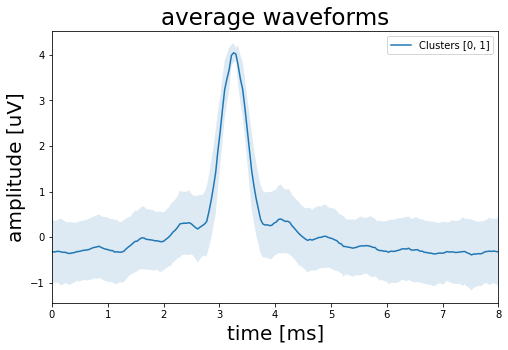

In [ ]:
combine_clusters = [0, 1]
combined_waveforms_mean = wave_form[[x in combine_clusters for x in cluster], :].mean(axis=0)
combined_waveforms_std = wave_form[[x in combine_clusters for x in cluster], :].std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(time, combined_waveforms_mean, label=f'Clusters {combine_clusters}')
ax.fill_between(time, combined_waveforms_mean-combined_waveforms_std, combined_waveforms_mean+combined_waveforms_std, 
                alpha=0.15)

ax.set_title('average waveforms', fontsize=23)
ax.set_xlim([0, time[-1]])
ax.set_xlabel('time [ms]', fontsize=20)
ax.set_ylabel('amplitude [uV]', fontsize=20)

plt.legend()
plt.show()

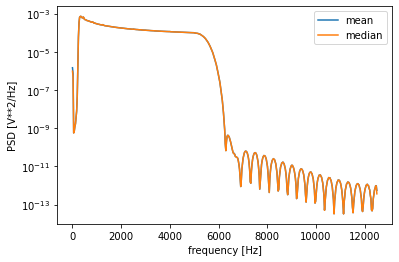

In [ ]:
f, Pxx_den = signal.welch(data, fs=25000, nperseg=1024)
f_med, Pxx_den_med = signal.welch(data, fs=25000, nperseg=1024, average='median')
plt.semilogy(f, Pxx_den, label='mean')
plt.semilogy(f_med, Pxx_den_med, label='median')
# plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

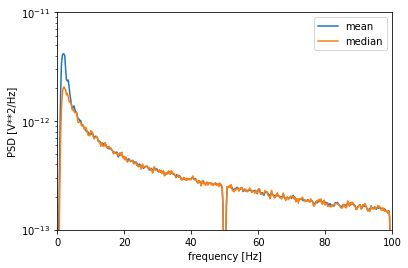

In [ ]:
# data1 = eeg_data.filter(1, 1000)
# data1 = data1.resample(sfreq=3000)
data = eeg_data.get_data()[0] - eeg_data.get_data()[1]
data1 = data[0:]
fs = 1000
win = 4 * fs
f, Pxx_den = signal.welch(data1, fs, nperseg=win)
f_med, Pxx_den_med = signal.welch(data1, fs, nperseg=win, average='median')
plt.semilogy(f, Pxx_den, label='mean')
plt.semilogy(f_med, Pxx_den_med, label='median')
plt.xlim([0, 100])
plt.ylim([10e-14, 10e-12])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

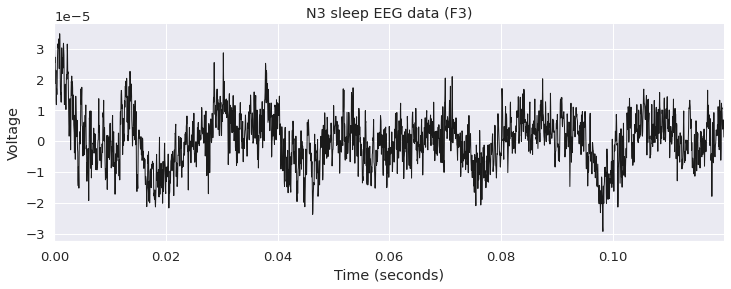

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
# sf = 100.
# eeg_data1 = eeg_data.copy().filter(l_freq=1, h_freq=50)
# eeg_data1 = eeg_data1.resample(sfreq=100)
time = np.arange(eeg_data.get_data()[0][100:100+3000].size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, eeg_data.get_data()[0][100:100+3000], lw=1., color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()

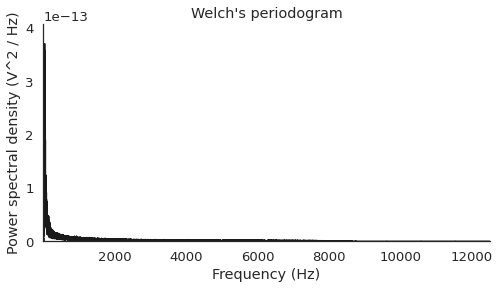

In [ ]:
from scipy import signal

# Define window length (4 seconds)
win = 10 * sf
freqs, psd = signal.welch(eeg_data.get_data()[1][1000:], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([1, freqs.max()])
sns.despine()



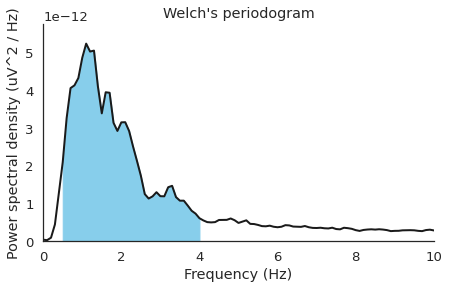

In [ ]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [ ]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 0.000 uV^2


In [ ]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lspopt import spectrogram_lspopt
from matplotlib.colors import Normalize, ListedColormap

__all__ = ['plot_spectrogram', 'topoplot']


def plot_spectrogram(data, sf, hypno=None, win_sec=30, fmin=0.5, fmax=25,
                     trimperc=2.5, cmap='RdBu_r'):
    """
    Plot a full-night multi-taper spectrogram, optionally with the hypnogram
    on top.
    For more details, please refer to the `Jupyter notebook
    <https://github.com/raphaelvallat/yasa/blob/master/notebooks/10_spectrogram.ipynb>`_
    .. versionadded:: 0.1.8
    Parameters
    ----------
    data : :py:class:`numpy.ndarray`
        Single-channel EEG data. Must be a 1D NumPy array.
    sf : float
        The sampling frequency of data AND the hypnogram.
   
    win_sec : int or float
        The length of the sliding window, in seconds, used for multitaper PSD
        calculation. Default is 30 seconds. Note that ``data`` must be at least
        twice longer than ``win_sec`` (e.g. 60 seconds).
    fmin, fmax : int or float
        The lower and upper frequency of the spectrogram. Default 0.5 to 25 Hz.
    trimperc : int or float
        The amount of data to trim on both ends of the distribution when
        normalizing the colormap. This parameter directly impacts the
        contrast of the spectrogram plot (higher values = higher contrast).
        Default is 2.5, meaning that the min and max of the colormap
        are defined as the 2.5 and 97.5 percentiles of the spectrogram.
    cmap : str
        Colormap. Default to 'RdBu_r'.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        Matplotlib Figure
    Examples
    --------
    1. Full-night multitaper spectrogram on Cz, no hypnogram
    .. plot::
        >>> import yasa
        >>> import numpy as np
        >>> # In the next 5 lines, we're loading the data from GitHub.
        >>> import requests
        >>> from io import BytesIO
        >>> r = requests.get('https://github.com/raphaelvallat/yasa/raw/master/notebooks/data_full_6hrs_100Hz_Cz%2BFz%2BPz.npz', stream=True)
        >>> npz = np.load(BytesIO(r.raw.read()))
        >>> data = npz.get('data')[0, :]
        >>> sf = 100
        >>> fig = yasa.plot_spectrogram(data, sf)
    2. Full-night multitaper spectrogram on Cz with the hypnogram on top
    .. plot::
        >>> import yasa
        >>> import numpy as np
        >>> # In the next lines, we're loading the data from GitHub.
        >>> import requests
        >>> from io import BytesIO
        >>> r = requests.get('https://github.com/raphaelvallat/yasa/raw/master/notebooks/data_full_6hrs_100Hz_Cz%2BFz%2BPz.npz', stream=True)
        >>> npz = np.load(BytesIO(r.raw.read()))
        >>> data = npz.get('data')[0, :]
        >>> sf = 100
        >>> # Load the 30-sec hypnogram and upsample to data
        >>> hypno = np.loadtxt('https://raw.githubusercontent.com/raphaelvallat/yasa/master/notebooks/data_full_6hrs_100Hz_hypno_30s.txt')
        >>> hypno = yasa.hypno_upsample_to_data(hypno, 1/30, data, sf)
        >>> fig = yasa.plot_spectrogram(data, sf, hypno, cmap='Spectral_r')
    """
    # Increase font size while preserving original
    old_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 18})

    # Safety checks
    assert isinstance(data, np.ndarray), 'Data must be a 1D NumPy array.'
    assert isinstance(sf, (int, float)), 'sf must be int or float.'
    assert data.ndim == 1, 'Data must be a 1D (single-channel) NumPy array.'
    assert isinstance(win_sec, (int, float)), 'win_sec must be int or float.'
    assert isinstance(fmin, (int, float)), 'fmin must be int or float.'
    assert isinstance(fmax, (int, float)), 'fmax must be int or float.'
    assert fmin < fmax, 'fmin must be strictly inferior to fmax.'
    assert fmax < sf / 2, 'fmax must be less than Nyquist (sf / 2).'

    # Calculate multi-taper spectrogram
    nperseg = int(win_sec * sf)
    assert data.size > 2 * nperseg, 'Data length must be at least 2 * win_sec.'
    f, t, Sxx = spectrogram_lspopt(data, sf, nperseg=nperseg, noverlap=0)
    Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz

    # Select only relevant frequencies (up to 30 Hz)
    good_freqs = np.logical_and(f >= fmin, f <= fmax)
    Sxx = Sxx[good_freqs, :]
    f = f[good_freqs]
    t /= 3600  # Convert t to hours

    # Normalization
    vmin, vmax = np.percentile(Sxx, [0 + trimperc, 100 - trimperc])
    norm = Normalize(vmin=vmin, vmax=vmax)

    if hypno is None:
        fig, ax = plt.subplots(nrows=1, figsize=(12, 4))
        im = ax.pcolormesh(t, f, Sxx, norm=norm, cmap=cmap, antialiased=True,
                           shading="auto")
        ax.set_xlim(0, t.max())
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [hrs]')

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, shrink=0.95, fraction=0.1, aspect=25)
        cbar.ax.set_ylabel('Log Power (dB / Hz)', rotation=270, labelpad=20)
        return fig
    else:
        hypno = np.asarray(hypno).astype(int)
        assert hypno.ndim == 1, 'Hypno must be 1D.'
        assert hypno.size == data.size, 'Hypno must have the same sf as data.'
        t_hyp = np.arange(hypno.size) / (sf * 3600)
        # Make sure that REM is displayed after Wake
        hypno = pd.Series(hypno).map({-2: -2, -1: -1, 0: 0, 1: 2,
                                      2: 3, 3: 4, 4: 1}).values
        hypno_rem = np.ma.masked_not_equal(hypno, 1)

        fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(12, 6),
                                       gridspec_kw={'height_ratios': [1, 2]})
        plt.subplots_adjust(hspace=0.1)

        # Hypnogram (top axis)
        ax0.step(t_hyp, -1 * hypno, color='k')
        ax0.step(t_hyp, -1 * hypno_rem, color='r')
        if -2 in hypno and -1 in hypno:
            # Both Unscored and Artefacts are present
            ax0.set_yticks([2, 1, 0, -1, -2, -3, -4])
            ax0.set_yticklabels(['Uns', 'Art', 'W', 'R', 'N1', 'N2', 'N3'])
            ax0.set_ylim(-4.5, 2.5)
        elif -2 in hypno and -1 not in hypno:
            # Only Unscored are present
            ax0.set_yticks([2, 0, -1, -2, -3, -4])
            ax0.set_yticklabels(['Uns', 'W', 'R', 'N1', 'N2', 'N3'])
            ax0.set_ylim(-4.5, 2.5)

        elif -2 not in hypno and -1 in hypno:
            # Only Artefacts are present
            ax0.set_yticks([1, 0, -1, -2, -3, -4])
            ax0.set_yticklabels(['Art', 'W', 'R', 'N1', 'N2', 'N3'])
            ax0.set_ylim(-4.5, 1.5)
        else:
            # No artefacts or Unscored
            ax0.set_yticks([0, -1, -2, -3, -4])
            ax0.set_yticklabels(['W', 'R', 'N1', 'N2', 'N3'])
            ax0.set_ylim(-4.5, 0.5)
        ax0.set_xlim(0, t_hyp.max())
        ax0.set_ylabel('Stage')
        ax0.xaxis.set_visible(False)
        ax0.spines['right'].set_visible(False)
        ax0.spines['top'].set_visible(False)

        # Spectrogram (bottom axis)
        im = ax1.pcolormesh(t, f, Sxx, norm=norm, cmap=cmap, antialiased=True,
                            shading="auto")
        ax1.set_xlim(0, t.max())
        ax1.set_ylabel('Frequency [Hz]')
        ax1.set_xlabel('Time [hrs]')

        # Revert font-size
        plt.rcParams.update({'font.size': old_fontsize})
        return 

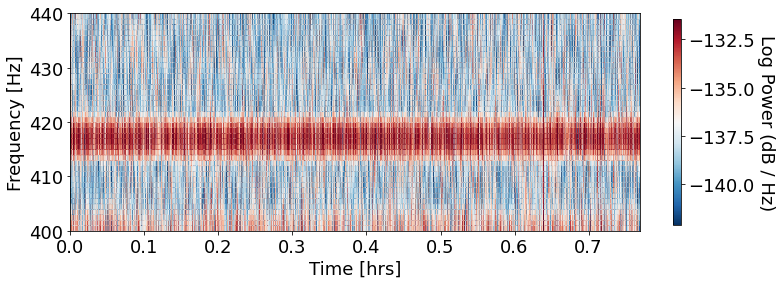

In [ ]:
plot_spectrogram(data[0:25000*60*46], sf=sf, win_sec=1, fmin=400, fmax=440,
                     trimperc=2.5, cmap='RdBu_r');

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

Estimated number of clusters: 1
Estimated number of noise points: 1


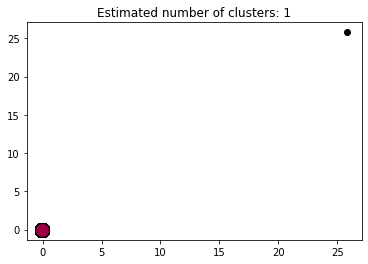

In [ ]:
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(
#     n_samples=750, centers=centers, cluster_std=0.4, random_state=0
# )

X = StandardScaler().fit_transform(wave_form)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0